# Classification with text and audio features
Updates: 
* 03/11 - reorganize the code and rename some variables, 
  change `X` to `x_text`, `X_train` to `x_txt_train`, `X_test` to `x_txt_test`, `Y` to `y_text`
* 03/18 - try NN
  see the 2 code blocks under the section "convert features and labels" if you're trying to get x and y for NN.


In [1]:
import sys
print(sys.executable)

/home/zyixian/anaconda3/envs/speech_gen/bin/python


In [2]:
!conda info


     active environment : /home/zyixian/anaconda3/envs/speech_gen
    active env location : /home/zyixian/anaconda3/envs/speech_gen
            shell level : 1
       user config file : /home/zyixian/.condarc
 populated config files : 
          conda version : 4.7.10
    conda-build version : 3.18.8
         python version : 3.7.3.final.0
       virtual packages : 
       base environment : /sw/arcts/centos7/python3.7-anaconda/2019.07  (read only)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /sw/arcts/centos7/python3.7-anaconda/2019.07/pkgs
                          /home/zyixian/.conda/pkgs
       envs directories : /home/zyixian/.conda/envs
                          /sw/arcts/centos7/python3.7-anaconda/2019.07/envs
               p

In [36]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd

import spacy
import string


from scipy.sparse import coo_matrix, hstack

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

import pickle

import imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours

from collections import Counter

from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

## ref: https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, is_mfcc, is_chroma, is_mel):
    
    X, sample_rate = librosa.load(file_name, sr=None, mono=True)
    
    if is_chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if is_mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if is_chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if is_mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result


#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2, is_mfcc=True, is_chroma=True, is_mel=True):
    x = []
    audio_list = sorted(os.listdir(train_dir))
    # gen = (x for x in audio_list)
    
    gen = (u for u in train_df[['Dialogue_ID', 'Utterance_ID']].values)
    for dia_utt in gen:
        dia_id = dia_utt[0]
        utt_id = dia_utt[1]
        file_name = f"dia{dia_id}_utt{utt_id}.wav"
        
        feature=extract_feature(train_dir + file_name, is_mfcc=is_mfcc, is_chroma=is_chroma, is_mel=is_mel)
        x.append(feature)
    
    labels_1d = np.reshape(labels_matrix, max_dia * max_utt)
    labels_1d = labels_1d[~np.equal(labels_1d, 99)]
    y = list(labels_1d)
    
    return x, y

### text feature generation
def cleaning(element):
    final_list = []
    """ Clean up text. Tokenize, lowercase, and remove punctuation and stopwords """
    #print("Running cleaner")
    # Remove punctuation, symbols (#) and stopwords
    element = str(element).lower()
    new_string = ''
    for char in element:
        if char not in punctuation_list:
            new_string += char
    all_wrds = new_string.split(" ")
    for word in all_wrds:
        if word not in stop_words_list:
            final_list.append(word)
    final_string = ' '.join(final_list)
    return final_string

def tokenize(str_arg):
    words = str_arg.split()
    return words



In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

Using TensorFlow backend.


In [6]:
max_dia = 1039
max_utt = 24
is_reload = False ## please set it to False if you are using features saved in pickle file 
test_size = 0.25
total = 9988

In [7]:
train_dir = "../data/train/"
emotions = ['neutral', 'surprise', 'fear', 'sadness', 'joy', 'disgust', 'anger']
emo2int = dict(zip(emotions, range(len(emotions))))
emo2int['empty'] = 99
int2emo = {v: k for k,v in emo2int.items()}
sentiments = ['negative', 'neutral', 'positive']
sent2int = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}
int2sent = {v: k for k, v in sent2int.items()}

## Extract audio features

In [8]:
train_df = pd.read_csv("../data/train_sent_emo.csv")
## dia125_utt_3 not working
remove_index = train_df[(train_df['Dialogue_ID'] == 125) & (train_df['Utterance_ID'] == 3)].index
train_df = train_df.drop(index=remove_index)

label_pivot = pd.pivot(data=train_df, columns="Utterance_ID", index="Dialogue_ID", values="Emotion").fillna("empty")
label_pivot.loc[60] = ["empty"] * label_pivot.shape[1] ## for some reasons, there is no dialogue 60.
label_pivot = label_pivot.sort_index()
label_pivot = label_pivot.applymap(lambda x: emo2int[x])
labels_matrix = label_pivot.values

In [9]:
train_df['sentiment_int'] = train_df['Sentiment'].apply(lambda x: sent2int[x])

In [10]:
train_df.iloc[1163:1166]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,sentiment_int
1163,1225,"Hey, if mommy can have a wife, daddy can have ...",Ross,neutral,neutral,125,1,4,18,"00:02:35,613","00:02:38,323",1
1164,1226,"Ohh, its time to go.",Emily,neutral,neutral,125,2,4,18,"00:02:40,869","00:02:42,119",1
1166,1228,"Huh, what can we do in 17 minutes?",Ross,neutral,neutral,125,4,4,18,"00:02:48,209","00:02:51,295",1


In [11]:
#DataFlair - Split the dataset
if is_reload:
    x_audio, y = load_data(test_size=test_size)
    with open("../data/train_audio_nomel.pickle", 'wb') as pickle_out:
        pickle.dump(x_audio, pickle_out)
    with open("../data/train_labels_nomel.pickle", 'wb') as pickle_out:
        pickle.dump(y, pickle_out)
else:
    with open("../data/train_audio.pickle", 'rb') as pickle_in:
        x_audio = pickle.load(pickle_in)
    with open("../data/train_labels.pickle", 'rb') as pickle_in:
        y = pickle.load(pickle_in)
## x_audio was named as x before

## Try some classifiers

In [64]:
# ## Multi-layer Perceptron with only audio
# x_au_train,x_test,y_train,y_test = train_test_split(np.array(x_audio), y, test_size=test_size, random_state=9)
# model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
# model.fit(x_au_train,y_train)
# y_pred=model.predict(x_test)

# print(classification_report(y_test, y_pred))

# print(classification_report(y_test, y_pred))

## Extract text features 
(code from EmotionBaseline.ipynb)

In [6]:
# !python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/zyixian/anaconda3/envs/speech_gen/lib/python3.8/site-packages/en_core_web_sm
-->
/home/zyixian/anaconda3/envs/speech_gen/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [15]:
nlp = spacy.load('en')
stop_words_list = list(spacy.lang.en.STOP_WORDS)
punctuation_list = list(string.punctuation)
punctuation_list.extend('\r')
punctuation_list.extend('\n')
punctuation_list.extend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [16]:
train_df['cleaned_Utterance'] = train_df['Utterance'].apply(cleaning)
train_df['tokens'] = train_df['cleaned_Utterance'].apply(tokenize)

train_df.index = range(total)
train_df.iloc[1163:1166]

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime,sentiment_int,cleaned_Utterance,tokens
1163,1225,"Hey, if mommy can have a wife, daddy can have ...",Ross,neutral,neutral,125,1,4,18,"00:02:35,613","00:02:38,323",1,hey mommy wife daddy bra,"[hey, mommy, wife, daddy, bra]"
1164,1226,"Ohh, its time to go.",Emily,neutral,neutral,125,2,4,18,"00:02:40,869","00:02:42,119",1,ohh its time,"[ohh, its, time]"
1165,1228,"Huh, what can we do in 17 minutes?",Ross,neutral,neutral,125,4,4,18,"00:02:48,209","00:02:51,295",1,huh minutes,"[huh, minutes]"


In [12]:
cleaned_utt = np.reshape(train_df['cleaned_Utterance'].values, (total,1))

In [13]:
for i in range(-10, 0):
    print(y[i], train_df['Emotion'].iloc[i])

1 surprise
0 neutral
0 neutral
5 disgust
5 disgust
0 neutral
0 neutral
1 surprise
0 neutral
4 joy


In [17]:
x_text = train_df['cleaned_Utterance'] # it was named as X
y_text = train_df['Emotion'] # was named as Y
x_txt_train, x_txt_test, y_txt_train, y_txt_test = train_test_split(x_text, y_text, test_size = test_size, random_state = 42)

## IMPORTANT there's no index 1165 before, run this to chech if you fixed the indices
[i for i in range(total + 1) if i not in y_text.index]

[9988]

In [18]:
aud_train = np.array(x_audio)[x_txt_train.index]
aud_test = np.array(x_audio)[x_txt_test.index]

In [16]:
## check whether they are aligned
for i in range(0, 10):
    print(y_txt_train[:10].values[i], train_df.loc[x_txt_train.index[:10]]['Emotion'].values[i])


neutral neutral
joy joy
surprise surprise
fear fear
fear fear
neutral neutral
surprise surprise
neutral neutral
neutral neutral
joy joy


In [19]:
count_vect = CountVectorizer()
x_txt_train_counts = count_vect.fit_transform(x_txt_train)
x_txt_test_counts = count_vect.transform(x_txt_test)

# x_txt_train_counts.shape #(7491, 4657)

# aud_train.shape #(7491, 180)

x_mix_train = hstack((x_txt_train_counts, aud_train))
x_mix_test = hstack((x_txt_test_counts, aud_test))

In [20]:
## sentiment
y_sent_train = train_df['sentiment_int'].values[y_txt_train.index]
y_sent_test = train_df['sentiment_int'].values[y_txt_test.index]

### convert features and lables

In [21]:
def convert_y(y_labels, num_class=2):
    """convert a list of labels to one-hot encoding for neural network"""
    if num_class > 2:
        encodings = np.zeros((len(y_labels), num_class))
    else:
        raise ValueError("Number of class should be greater than 2, num_class =", num_class)
    for i, this_y in enumerate(y_labels):
        encodings[i, this_y] = 1
    return encodings

In [22]:
x_arr_train = x_mix_train.toarray()
x_arr_test = x_mix_test.toarray()

y_num_train = np.array(y)[y_txt_train.index] ## number labels for emotions
y_num_test = np.array(y)[y_txt_test.index]
y_1hot_train = convert_y(y_num_train, 7)
y_1hot_test = convert_y(y_num_test, 7)

input_shape = x_mix_train.shape[1]

In [21]:
log_clf_wgt = LogisticRegression(class_weight='balanced').fit(x_mix_train, y_txt_train)

y_log_pred = log_clf_wgt.predict(x_mix_test)
accuracy = accuracy_score(np.array(y_txt_test), y_log_pred)
# Combined report with all above metrics
print(classification_report(y_txt_test, y_log_pred))

              precision    recall  f1-score   support

       anger       0.24      0.29      0.26       312
     disgust       0.06      0.35      0.10        65
        fear       0.02      0.12      0.04        57
         joy       0.24      0.17      0.20       422
     neutral       0.58      0.22      0.32      1152
     sadness       0.11      0.28      0.15       160
    surprise       0.21      0.17      0.19       329

    accuracy                           0.22      2497
   macro avg       0.21      0.23      0.18      2497
weighted avg       0.37      0.22      0.25      2497



/home/zyixian/anaconda3/envs/speech_gen/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Logistic with Grid Search

In [18]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'C' : [0.5, 0.8, 0.9, 1, 1.2, 1.5, 2, 5],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
log_clf = GridSearchCV(logit, param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1)

# Fit on data
grid_cv =log_clf.fit(x_mix_train, y_txt_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  8.0min finished


In [81]:
results = pd.DataFrame(grid_cv.cv_results_).sort_values(['rank_test_score'])
results.head(6)
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_wgt_params = results[results['param_class_weight'] == "balanced"].head(1)['params'].values[0]
best_wgt_params

{'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

In [190]:
best_wgt_params = {'C': 0.8, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
base_logit_wgt = LogisticRegression(random_state=1, **best_wgt_params)
base_logit_wgt.fit(x_txt_train_counts, y_txt_train)
base_logit_wgt_pred = base_logit_wgt.predict(x_txt_test_counts)
print(classification_report(y_txt_test, base_logit_wgt_pred))

              precision    recall  f1-score   support

       anger       0.26      0.20      0.22       312
     disgust       0.14      0.18      0.16        65
        fear       0.08      0.14      0.10        57
         joy       0.39      0.35      0.37       422
     neutral       0.57      0.63      0.60      1152
     sadness       0.18      0.18      0.18       160
    surprise       0.42      0.35      0.38       329

    accuracy                           0.44      2497
   macro avg       0.29      0.29      0.29      2497
weighted avg       0.43      0.44      0.43      2497



In [16]:
best_logit_wgt = LogisticRegression(random_state=1, **best_wgt_params)
best_logit_wgt.fit(x_mix_train, y_txt_train)
best_logit_wgt_pred = best_logit_wgt.predict(x_mix_test)
print(classification_report(y_txt_test, best_logit_wgt_pred))

NameError: name 'best_wgt_params' is not defined

In [17]:
best_logit = LogisticRegression(random_state=1, **grid_cv.best_params_)
best_logit.fit(x_mix_train, y_txt_train)
best_logit_unwgt = best_logit.predict(x_mix_test)
best_logit

NameError: name 'grid_cv' is not defined

In [90]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.37      0.14      0.20       312
     disgust       0.50      0.02      0.03        65
        fear       0.17      0.02      0.03        57
         joy       0.46      0.21      0.29       422
     neutral       0.52      0.92      0.66      1152
     sadness       0.32      0.07      0.12       160
    surprise       0.65      0.19      0.29       329

    accuracy                           0.51      2497
   macro avg       0.43      0.22      0.23      2497
weighted avg       0.49      0.51      0.43      2497



In [85]:
best_logit_wgt

array(['neutral', 'neutral', 'neutral', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [77]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.37      0.14      0.20       312
     disgust       0.50      0.02      0.03        65
        fear       0.17      0.02      0.03        57
         joy       0.46      0.21      0.29       422
     neutral       0.52      0.92      0.66      1152
     sadness       0.32      0.07      0.12       160
    surprise       0.65      0.19      0.29       329

    accuracy                           0.51      2497
   macro avg       0.43      0.22      0.23      2497
weighted avg       0.49      0.51      0.43      2497



In [68]:
print(classification_report(y_txt_test, best_logit_unwgt))

              precision    recall  f1-score   support

       anger       0.39      0.18      0.25       312
     disgust       0.20      0.02      0.03        65
        fear       0.18      0.04      0.06        57
         joy       0.43      0.23      0.30       422
     neutral       0.53      0.89      0.66      1152
     sadness       0.29      0.09      0.13       160
    surprise       0.53      0.22      0.32       329

    accuracy                           0.51      2497
   macro avg       0.36      0.24      0.25      2497
weighted avg       0.46      0.51      0.44      2497



In [99]:
model2=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)
model2.fit(x_txt_train_mix, Y_train)
y_pred=model2.predict(x_txt_test_mix)


              precision    recall  f1-score   support

           0       0.63      0.33      0.43       453
           1       0.30      0.54      0.38       133
           2       0.07      0.24      0.11        21
           3       0.17      0.20      0.19        71
           4       0.39      0.40      0.40       177
           5       0.07      0.16      0.10        25
           6       0.20      0.23      0.22       119

    accuracy                           0.34       999
   macro avg       0.26      0.30      0.26       999
weighted avg       0.43      0.34      0.36       999



In [100]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       453
           1       0.32      0.37      0.34       133
           2       0.04      0.05      0.04        21
           3       0.14      0.07      0.09        71
           4       0.25      0.45      0.32       177
           5       0.08      0.04      0.05        25
           6       0.18      0.13      0.15       119

    accuracy                           0.35       999
   macro avg       0.22      0.22      0.21       999
weighted avg       0.37      0.35      0.35       999



In [101]:
## using logistic on only audio data
log_clf_wgt2 = LogisticRegression(class_weight='balanced').fit(x_train, y_train)
y_pred_log2 = log_clf_wgt2.predict(x_test)
print(classification_report(y_test, y_pred_log2))

              precision    recall  f1-score   support

           0       0.55      0.20      0.29      1152
           1       0.13      0.12      0.12       308
           2       0.04      0.18      0.07        62
           3       0.11      0.25      0.15       185
           4       0.26      0.20      0.23       439
           5       0.04      0.27      0.07        64
           6       0.24      0.31      0.27       287

    accuracy                           0.21      2497
   macro avg       0.20      0.22      0.17      2497
weighted avg       0.35      0.21      0.24      2497



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [26]:
sample_rate = 44100
this_audio = train_dir + "dia39_utt16.wav"
X, sr = librosa.load(this_audio, sr=None, mono=True)

In [27]:
stft=np.abs(librosa.stft(X))
stft.shape

(1025, 833)

In [28]:
result=np.array([])
mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40).T, axis=0)
result=np.hstack((result, mfccs))

## Emotion classification using a Simple NN

In [70]:
simple_nn = models.Sequential()
simple_nn.add(layers.Dense(32, activation='relu', input_shape=(input_shape, )))
simple_nn.add(layers.Dense(16, activation='relu'))
simple_nn.add(layers.Dense(7, activation='softmax'))
simple_nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
simple_nn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                154816    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 119       
Total params: 155,463
Trainable params: 155,463
Non-trainable params: 0
_________________________________________________________________


In [36]:
x_mix_test.toarray()

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74471360e-09, 1.72682491e-09, 1.69412095e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46812584e-07, 3.42379650e-07, 3.40634188e-07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.26655038e-07, 1.24367318e-07, 1.23367855e-07],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.23652277e-09, 5.20029309e-09, 5.06713382e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.38951861e-09, 1.39165923e-09, 1.40881651e-09],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.01268953e-08, 7.71062858e-08, 7.68958301e-08]])

In [58]:
history = simple_nn.fit(x_arr_train, y_1hot_train, epochs=25, batch_size=128, verbose=0)
y_nn_predict = simple_nn.predict(x_arr_test)

Epoch 1/25
7491/7491 [==============================] - 1s 159us/step - loss: 0.6053 - accuracy: 0.7975
Epoch 2/25
7491/7491 [==============================] - 1s 114us/step - loss: 0.5869 - accuracy: 0.8023
Epoch 3/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.5911 - accuracy: 0.7992
Epoch 4/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.6449 - accuracy: 0.7817
Epoch 5/25
7491/7491 [==============================] - 1s 114us/step - loss: 0.6033 - accuracy: 0.7915
Epoch 6/25
7491/7491 [==============================] - 1s 119us/step - loss: 0.5929 - accuracy: 0.8034
Epoch 7/25
7491/7491 [==============================] - 1s 132us/step - loss: 0.5959 - accuracy: 0.7987
Epoch 8/25
7491/7491 [==============================] - 1s 116us/step - loss: 0.5811 - accuracy: 0.8024
Epoch 9/25
7491/7491 [==============================] - 1s 132us/step - loss: 0.5764 - accuracy: 0.8035
Epoch 10/25
7491/7491 [==============================] - 1s 132u

In [68]:
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.56      0.63      0.59      1152
    surprise       0.39      0.22      0.28       329
        fear       0.06      0.04      0.05        57
     sadness       0.14      0.11      0.12       160
         joy       0.32      0.41      0.36       422
     disgust       0.11      0.11      0.11        65
       anger       0.29      0.24      0.26       312

    accuracy                           0.43      2497
   macro avg       0.27      0.25      0.25      2497
weighted avg       0.41      0.43      0.42      2497



In [62]:
np.argmax(y_1hot_test, axis=1)

array([3, 0, 3, ..., 4, 3, 0])

In [61]:
np.argmax(y_nn_predict, axis=1)

array([0, 4, 0, ..., 4, 0, 4])

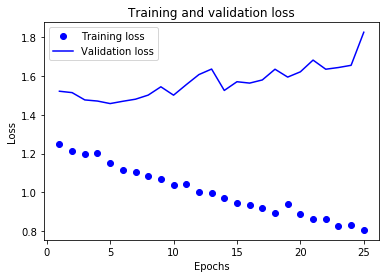

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [53]:
epochs

range(1, 26)

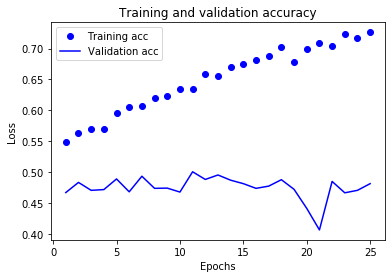

In [54]:
plt.clf()   # clear figure
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## MLP with regularization

In [88]:
from keras.constraints import unit_norm, min_max_norm
from keras.callbacks import EarlyStopping

In [209]:
nn_model2 = models.Sequential()
nn_model2.add(layers.Dense(32, activation='tanh', input_shape=(input_shape, ), kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm()))
nn_model2.add(layers.Dropout(0.2))
nn_model2.add(layers.Dense(16, activation='tanh'))
nn_model2.add(layers.Dropout(0.2))
nn_model2.add(layers.Dense(7, activation='softmax'))
nn_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [213]:
es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1)

history2 = nn_model2.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.15, verbose=0, callbacks=[es]) #


Epoch 00002: early stopping


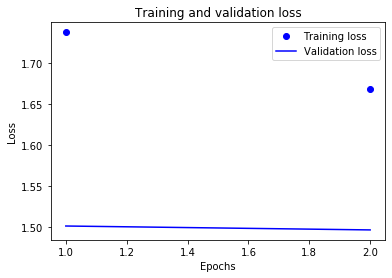

In [211]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

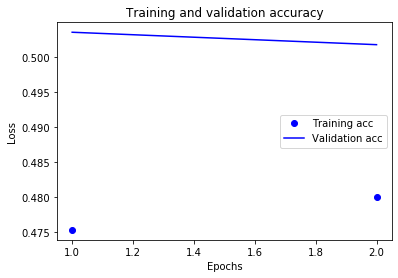

In [141]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [214]:
y_nn_predict2 = nn_model2.predict(x_arr_test)
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict2, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.46      1.00      0.63      1152
    surprise       0.00      0.00      0.00       329
        fear       0.00      0.00      0.00        57
     sadness       0.00      0.00      0.00       160
         joy       0.00      0.00      0.00       422
     disgust       0.00      0.00      0.00        65
       anger       0.00      0.00      0.00       312

    accuracy                           0.46      2497
   macro avg       0.07      0.14      0.09      2497
weighted avg       0.21      0.46      0.29      2497



## Sentiment

In [158]:
np.unique(y_sent_train)

array([0, 1, 2])

In [178]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': ['balanced'], # , None
    'C' : [0.1, 0.5, 0.7, 1, 7, 10, 15, 20],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
grid_cv_sent = GridSearchCV(logit, param_grid = param_grid, cv = 4, verbose=2, n_jobs=-1).fit(x_mix_train, y_sent_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 10.1min finished


In [179]:
results = pd.DataFrame(grid_cv_sent.cv_results_).sort_values(['rank_test_score'])
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,13.429574,3.716243,0.008193,0.003015,0.5,balanced,l1,liblinear,"{'C': 0.5, 'class_weight': 'balanced', 'penalt...",0.510411,0.531767,0.556327,0.532585,0.532773,0.016247,1
6,23.079005,2.335466,0.011178,0.004238,1,balanced,l1,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.514148,0.532301,0.560064,0.519765,0.531570,0.017715,2
4,16.339657,1.398755,0.005232,0.001057,0.7,balanced,l1,liblinear,"{'C': 0.7, 'class_weight': 'balanced', 'penalt...",0.514682,0.532835,0.557928,0.518697,0.531036,0.016927,3
11,50.828467,1.226927,0.004471,0.000415,10,balanced,l2,liblinear,"{'C': 10, 'class_weight': 'balanced', 'penalty...",0.515216,0.533369,0.556327,0.518697,0.530902,0.016183,4
7,51.828973,1.984817,0.004736,0.000383,1,balanced,l2,liblinear,"{'C': 1, 'class_weight': 'balanced', 'penalty'...",0.515216,0.531767,0.553657,0.521368,0.530502,0.014619,5
13,47.941090,2.707076,0.004719,0.000448,15,balanced,l2,liblinear,"{'C': 15, 'class_weight': 'balanced', 'penalty...",0.516284,0.535505,0.554191,0.516026,0.530501,0.015795,6
9,54.444333,3.042131,0.005599,0.001048,7,balanced,l2,liblinear,"{'C': 7, 'class_weight': 'balanced', 'penalty'...",0.515750,0.528564,0.556327,0.517094,0.529434,0.016306,7
1,20.624824,1.828291,0.004367,0.000168,0.1,balanced,l2,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",0.507208,0.524826,0.553123,0.532051,0.529302,0.016456,8
3,44.650046,3.442787,0.004812,0.000486,0.5,balanced,l2,liblinear,"{'C': 0.5, 'class_weight': 'balanced', 'penalt...",0.510411,0.532301,0.557395,0.514957,0.528766,0.018437,9
5,49.786807,4.478527,0.015125,0.006583,0.7,balanced,l2,liblinear,"{'C': 0.7, 'class_weight': 'balanced', 'penalt...",0.513615,0.532301,0.552589,0.515491,0.528499,0.015697,10


In [180]:
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_sent_wgt_params = results[results['param_class_weight'] == "balanced"].head(1)['params'].values[0]
best_sent_wgt_params

{'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

In [199]:
best_sent_logit_wgt = LogisticRegression(random_state=1, **best_sent_wgt_params)
best_sent_logit_wgt.fit(x_mix_train, y_sent_train)
best_sent_wgt_pred = best_sent_logit_wgt.predict(x_mix_test)


In [200]:
print(classification_report(y_sent_test, best_sent_wgt_pred, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.52      0.48      0.50       779
     neutral       0.60      0.71      0.65      1152
    positive       0.46      0.33      0.39       566

    accuracy                           0.55      2497
   macro avg       0.53      0.51      0.51      2497
weighted avg       0.54      0.55      0.54      2497



### unweighted

In [173]:
# best score may lie between C=[0.1, 10], l1 or l2, need deeper search
best_sent_unwgt_params = results.head(1)['params'].values[0]
best_sent_unwgt_params

{'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

In [174]:
best_sent_logit_unwgt = LogisticRegression(random_state=1, **best_sent_unwgt_params)
best_sent_logit_unwgt.fit(x_mix_train, y_sent_train)
best_sent_unwgt_pred = best_sent_logit_unwgt.predict(x_mix_test)

In [177]:
print(classification_report(y_sent_test, best_sent_unwgt_pred, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.55      0.36      0.44       779
     neutral       0.55      0.84      0.66      1152
    positive       0.51      0.22      0.31       566

    accuracy                           0.55      2497
   macro avg       0.54      0.47      0.47      2497
weighted avg       0.54      0.55      0.51      2497



## Try to solve the problem of always predicting the neurtral class

Changing learning rate helps
Added more layers

In [267]:
from keras.layers import Dense, Dropout
from keras.initializers import RandomUniform
from keras.optimizers import Adam
import tensorflow as tf

In [268]:
## reference: https://www.dlology.com/blog/multi-class-classification-with-focal-loss-for-imbalanced-datasets/
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [269]:
nn_model3 = models.Sequential()
nn_model3.add(Dense(64, activation='tanh', input_shape=(input_shape, ), kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm(),\
                    kernel_initializer=RandomUniform(minval=-0.1, maxval=+0.1)))
nn_model3.add(Dense(32, activation='tanh', kernel_constraint=min_max_norm(-2, 2), bias_constraint=unit_norm()))
nn_model3.add(Dense(16, activation='tanh'))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(16, activation='tanh', kernel_constraint=min_max_norm(-3, 3), bias_constraint=unit_norm()))
nn_model3.add(Dropout(0.2))
nn_model3.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate=0.00001)
nn_model3.compile(loss=focal_loss(alpha=1), optimizer='adam', metrics=['categorical_accuracy'])

In [270]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history2 = nn_model3.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.2, verbose=0, callbacks=[es]) 


# history2 = nn_model3.fit(x_arr_train, y_1hot_train, epochs=15, batch_size=128, validation_split=0.2, verbose=0) #, callbacks=[es]


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 00002: early stopping


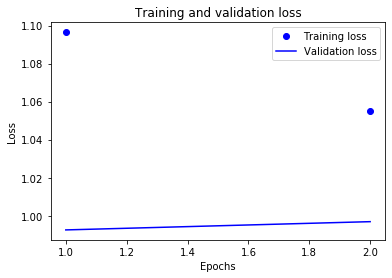

In [272]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

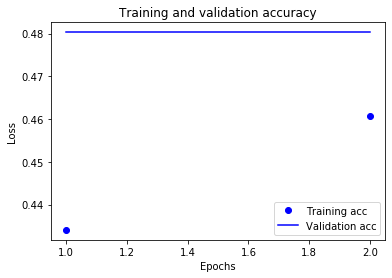

In [273]:
acc = history2.history['categorical_accuracy']
val_acc = history2.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [274]:
y_nn_predict3 = nn_model3.predict(x_arr_test)
print(classification_report(np.argmax(y_1hot_test, axis=1), np.argmax(y_nn_predict3, axis=1), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.46      1.00      0.63      1152
    surprise       0.00      0.00      0.00       329
        fear       0.00      0.00      0.00        57
     sadness       0.00      0.00      0.00       160
         joy       0.00      0.00      0.00       422
     disgust       0.00      0.00      0.00        65
       anger       0.00      0.00      0.00       312

    accuracy                           0.46      2497
   macro avg       0.07      0.14      0.09      2497
weighted avg       0.21      0.46      0.29      2497



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Oversampling

In [38]:
label_counts = Counter(y_num_train)

over_dicts = []
for delta in [200, 500, 800]:
    resample_dict = {l: ct + delta for l, ct in label_counts.items() if l != 0}
#     resample_dict[0] -= delta
    over_dicts.append(resample_dict)

under_dicts = []
for delta in [200, 500, 1000]:
    resample_dict = {0: 2963 - delta}
    under_dicts.append(resample_dict)
    

neutral_count = int(3557 * 5/6)

Counter(y_num_train)
over_dicts

[{4: 1521, 1: 1076, 2: 411, 5: 406, 6: 997, 3: 723},
 {4: 1821, 1: 1376, 2: 711, 5: 706, 6: 1297, 3: 1023},
 {4: 2121, 1: 1676, 2: 1011, 5: 1006, 6: 1597, 3: 1323}]

In [41]:
resample_dict

{0: 4709, 1: 1405, 2: 468, 3: 883, 4: 1943, 5: 471, 6: 1309}

In [69]:
under = RandomUnderSampler(sampling_strategy={0: 3000})
x_new_train, y_new_train = under.fit_resample(x_new_train, y_new_train)

print(Counter(y_new_train))

Counter({0: 3000, 4: 1943, 1: 1405, 6: 1309, 3: 883, 5: 471, 2: 468})


In [92]:
def wrappedSMOTE(label_counts=label_counts, delta=200, k=5):
    """wrapped SMOTE for pipline/gridsearch"""
    resample_dict = {l: ct + delta for l, ct in label_counts.items()}
    resample_dict[0] -= delta
    smote = SMOTE(sampling_strategy=resample_dict, k_neighbors=k)
    return smote


In [93]:
def wrappedRUS(delta=200):
    """wrapped RandomUnderSampler for pipline/gridsearch"""
    resample_dict = {0: 3557 - delta}
    rus = RandomUnderSampler(sampling_strategy=resample_dict)
    return rus

In [94]:
temp= wrappedSMOTE(delta=2000)
x_new_train, y_new_train = temp.fit_resample(x_mix_train, y_num_train)
print(Counter(y_new_train))

Counter({0: 3557, 4: 3321, 1: 2876, 6: 2797, 3: 2523, 2: 2211, 5: 2206})


In [23]:
model = LogisticRegression(random_state=1)
over = RandomOverSampler()
under = RandomUnderSampler() # random
pipe = imblearn.pipeline.Pipeline(steps=[('o', over), ('u', under), ('m', model)])

# over.get_params().keys()

In [24]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [25]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipe, x_mix_train, y_num_train, scoring='f1_weighted', cv=cv, n_jobs=-1)
print('Mean f1_weighted: %.3f' % mean(scores))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9), SIGKILL(-9), SIGKILL(-9)}

In [51]:
sum(label_counts.values())

7491

In [52]:
sum(Counter(y_new_train).values())

11497

In [38]:
param_grid = {
    'o__sampling_strategy': over_dicts,
#     'o__k_neighbors': [3, 5, 7, 9],
    'u__sampling_strategy': under_dicts,
    'm__penalty' : ['l1', 'l2'],
    'm__class_weight': ['balanced', None],
    'm__C' : [1, 5, 10, 100, 1000],
    'm__solver' : ['liblinear']}

# Create grid search object
grid_cv = GridSearchCV(pipe, param_grid = param_grid, scoring="f1_weighted", cv = 5, verbose=2, n_jobs=32).fit(x_mix_train, y_num_train)

results = pd.DataFrame(grid_cv.cv_results_).sort_values(['rank_test_score'])
results.head(4)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9), SIGKILL(-9)}

In [33]:
grid_cv

NameError: name 'grid_cv' is not defined

In [33]:
temp=["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
labels_ordered = [emo2int[x] for x in temp]

In [55]:
# print(label_counts)
# maj_count = label_counts[0]
# delta = 200
# resample_dict = {}
# for l, ct in label_counts.items():
# #     print(f"{l}: {ct/maj_count: .2f}")
#     resample_dict[l] = ct + delta
#     print(f"{l}: {resample_dict[l] / maj_count: .2f}")
    
# resample_dict[0] -= delta
over = SMOTE(sampling_strategy=over_dicts[1], k_neighbors=10)
under = RandomUnderSampler(sampling_strategy=under_dicts[0])
x_new_train, y_new_train = over.fit_resample(x_mix_train, y_num_train)
x_new_train, y_new_train = under.fit_resample(x_new_train, y_new_train)

print(Counter(y_new_train))

Counter({0: 2763, 4: 1821, 1: 1376, 6: 1297, 3: 1023, 2: 711, 5: 706})


In [56]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': [ None],
    'C' : [1, 10, 15, 20, 50, 100, 200],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
grid_cv = GridSearchCV(logit, param_grid = param_grid, cv = 7, verbose=2, n_jobs=-1).fit(x_new_train, y_new_train)


Fitting 7 folds for each of 14 candidates, totalling 98 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  77 out of  98 | elapsed:  3.4min remaining:   55.2s
[Parallel(n_jobs=-1)]: Done  98 out of  98 | elapsed:  4.3min finished


In [48]:
results = pd.DataFrame(grid_cv.cv_results_).sort_values(['rank_test_score'])
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
14,123.108476,16.871889,0.005504,0.000482,20,None,l1,liblinear,"{'C': 20, 'class_weight': None, 'penalty': 'l1...",0.596398,0.580387,0.603069,0.607071,0.656438,0.742991,0.753004,0.648480,0.066598,1
10,103.822872,15.831743,0.005849,0.000767,5,None,l1,liblinear,"{'C': 5, 'class_weight': None, 'penalty': 'l1'...",0.595730,0.591728,0.594396,0.609073,0.658439,0.734312,0.739653,0.646190,0.061206,2
22,137.591704,32.550447,0.009857,0.005638,100,None,l1,liblinear,"{'C': 100, 'class_weight': None, 'penalty': 'l...",0.579053,0.574383,0.596398,0.602402,0.656438,0.744993,0.751669,0.643619,0.070718,3
18,133.427174,11.621387,0.008219,0.005144,50,None,l1,liblinear,"{'C': 50, 'class_weight': None, 'penalty': 'l1...",0.579720,0.576384,0.598399,0.602402,0.652435,0.742323,0.749666,0.643047,0.069087,4
26,128.798480,14.023403,0.005232,0.000167,200,None,l1,liblinear,"{'C': 200, 'class_weight': None, 'penalty': 'l...",0.573049,0.570380,0.594396,0.601067,0.654436,0.740988,0.757009,0.641618,0.072708,5
12,147.836307,37.810413,0.005285,0.000201,20,balanced,l1,liblinear,"{'C': 20, 'class_weight': 'balanced', 'penalty...",0.574383,0.577718,0.585057,0.603736,0.641761,0.732977,0.749666,0.637900,0.068829,6
8,100.555070,18.467646,0.005412,0.000372,5,balanced,l1,liblinear,"{'C': 5, 'class_weight': 'balanced', 'penalty'...",0.578386,0.570380,0.588392,0.605070,0.647098,0.726969,0.732977,0.635610,0.063976,7
30,127.165115,28.482574,0.004749,0.000070,1000,None,l1,liblinear,"{'C': 1000, 'class_weight': None, 'penalty': '...",0.567712,0.561708,0.581054,0.594396,0.643095,0.742323,0.751001,0.634470,0.075116,8
16,161.973315,30.933308,0.005681,0.001075,50,balanced,l1,liblinear,"{'C': 50, 'class_weight': 'balanced', 'penalty...",0.567712,0.569713,0.589726,0.598399,0.638426,0.730307,0.746996,0.634468,0.069504,9
20,170.430797,24.393236,0.005632,0.000925,100,balanced,l1,liblinear,"{'C': 100, 'class_weight': 'balanced', 'penalt...",0.569046,0.558372,0.585057,0.604403,0.635090,0.736315,0.749666,0.633993,0.072760,10


In [43]:
# logistic regression with oversampling
best_logit = LogisticRegression(random_state=1, **grid_cv.best_params_)
best_logit.fit(x_new_train, y_new_train)
y_predict = best_logit.predict(x_mix_test)

print(classification_report(y_num_test, y_predict, labels=labels_ordered, target_names=temp))

              precision    recall  f1-score   support

       anger       0.26      0.22      0.24       312
     disgust       0.13      0.14      0.14        65
        fear       0.06      0.11      0.08        57
         joy       0.34      0.32      0.33       422
     neutral       0.57      0.58      0.57      1152
     sadness       0.15      0.15      0.15       160
    surprise       0.32      0.30      0.31       329

    accuracy                           0.41      2497
   macro avg       0.26      0.26      0.26      2497
weighted avg       0.41      0.41      0.41      2497



In [35]:
mapping_df.shape

(9988, 1)

## using audio embeddings

In [36]:
audio_emb.shape

(9000, 20)

In [12]:
audio_emb_raw = pd.read_csv("../data/audio_embeddings.csv", index_col=0)

mapping_df = train_df[["Dialogue_ID", "Utterance_ID"]].copy()
mapping_df['name'] = mapping_df.apply(lambda x: f"dia{x['Dialogue_ID']}_utt{x['Utterance_ID']}", axis=1)
mapping_df = mapping_df.drop(columns=["Dialogue_ID", "Utterance_ID"])
mapping_df.head()

audio_emb = pd.merge(mapping_df, audio_emb_raw, left_on="name", right_index=True, how="inner")
audio_emb = audio_emb.drop(columns=['name'])
audio_emb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.468404,0.278676,-0.466101,-0.841499,0.811462,0.994261,0.079472,0.331361,0.709990,-0.652272,0.534986,-0.043683,0.237591,-0.517976,-0.125858,-0.664146,-0.092333,0.472566,-0.217704,-1.215915
1,0.393439,-0.049780,0.540950,0.341101,-1.450056,-0.316093,0.223109,-0.665428,-0.001696,-0.214290,-0.177799,2.145403,-1.066256,1.891518,0.460961,-2.707002,1.432687,1.104046,-0.708277,0.283212
2,0.242229,-0.049403,0.381951,-0.164425,-2.974038,0.140854,1.391142,-1.324422,1.446847,0.098883,-0.528462,3.522814,-1.228283,1.477336,0.621532,-2.735992,0.292453,-0.049170,-1.240625,0.957958
3,0.236312,-0.058175,0.145887,-0.038939,-0.915901,-0.452194,0.519279,-0.432044,0.827844,0.061658,-0.133397,1.377155,-0.490001,0.785380,-0.090981,-1.176765,0.576154,0.372343,-0.720053,0.481285
4,0.494084,-0.414193,0.686100,-0.079510,-2.225597,0.112894,0.940339,-1.034066,0.878203,-0.171336,-0.101157,2.875808,-0.771293,1.821688,0.622958,-2.121955,1.127253,1.203245,-0.917203,0.686002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,0.317646,0.127494,0.561333,-0.170620,-2.089635,-0.319585,0.702855,-0.999539,1.182079,0.222808,-0.081520,2.877434,-0.913109,1.734860,-0.157258,-2.513618,0.939858,1.602317,-1.390440,0.395372
9985,-0.254540,0.392315,2.296835,-1.325808,-3.301410,-0.205515,2.201517,-1.735718,2.608117,0.042434,-1.344730,4.906795,-0.918109,0.927062,1.368234,-2.642496,-0.844671,0.537211,-1.962808,0.413894
9986,-0.025878,-0.096097,0.010346,0.005652,-0.669789,-0.851164,0.641215,-0.100471,0.936295,0.300127,-0.186234,1.266441,-0.496933,0.685078,-0.470907,-0.906288,0.549094,0.835844,-0.940960,0.552636
9987,0.229676,0.241477,1.348317,-0.423532,-2.928809,0.004402,1.284401,-1.472378,1.175798,-0.138858,-0.212625,3.868988,-1.018544,1.744546,1.180914,-2.500556,0.760446,1.459516,-1.314147,0.297955


In [13]:
audio_emb_raw.shape

(9000, 20)

In [46]:
audio_emb[audio_emb.isna().any(axis=1)]

,name,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
5,dia0_utt5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,dia0_utt7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,dia2_utt4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,dia3_utt6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,dia5_utt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9936,dia1034_utt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9945,dia1035_utt6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9955,dia1036_utt9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9966,dia1036_utt20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
train_subset = pd.merge(x_txt_train.to_frame(), audio_emb, left_index=True, right_index=True, how='inner').drop(columns=['cleaned_Utterance'])
test_subset = pd.merge(x_txt_test.to_frame(), audio_emb, left_index=True, right_index=True).drop(columns=['cleaned_Utterance'])

In [72]:
train_subset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2022,0.380136,0.013557,0.444868,-0.159154,-1.882184,-0.540239,0.408776,-1.003661,0.658224,-0.132428,-0.003633,2.374494,-0.924737,1.911677,0.182614,-2.683055,1.372901,1.415666,-1.037116,0.627431
9873,0.289691,-0.109464,-0.062073,0.069794,-0.060432,-0.338151,0.501673,0.022923,1.027111,-0.157100,0.306545,0.721678,0.282060,1.033581,-0.337916,-1.303151,0.790982,1.671680,-0.667830,0.188300
2542,0.051725,0.014099,-0.670242,0.301025,0.911384,-0.825443,-0.268050,0.684835,0.127059,0.184599,0.328975,-0.417977,0.437139,0.252209,-0.898743,-0.021114,0.432363,0.385303,0.062679,0.707053
2732,0.184398,-0.174997,1.742006,-0.606104,-2.578461,-0.553388,1.377012,-1.053009,1.777836,-0.157670,-0.558999,3.678346,-0.997593,1.036072,0.981599,-1.818053,0.708083,1.311199,-1.387904,0.121383
8653,0.273693,0.029989,-0.293199,0.162781,0.058210,-0.401742,-0.079954,0.093336,0.364464,-0.062191,0.248690,0.318145,-0.248417,0.583351,-0.554918,-0.944436,0.633883,1.261529,-0.604498,0.177346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.426053,0.128535,0.595150,0.171173,-1.627591,-0.138677,0.623442,-0.846837,0.867146,0.161239,0.045224,2.244308,-0.722979,1.328255,0.217344,-1.890015,0.727113,1.181411,-0.963641,0.026678
5191,0.235136,-0.023087,0.553511,-0.039840,-1.806681,-0.424436,0.561687,-1.063671,1.194095,-0.208619,-0.022236,2.639043,-0.603684,1.461889,0.264556,-2.185811,1.075058,1.943642,-1.133654,0.504604
5390,0.026033,0.291060,0.101757,0.485716,-0.959205,-0.201362,0.306136,-0.233086,0.614675,0.130512,-0.109402,1.650035,-0.616668,1.207558,0.079381,-1.866822,0.954838,1.295008,-0.491225,0.109172
860,0.340456,0.124504,0.706386,-0.039325,-1.869652,-0.090968,0.572494,-1.036518,0.431760,-0.094413,-0.080917,2.288663,-0.692704,1.438392,0.551767,-2.188156,0.981590,1.238949,-0.646491,0.325857


In [24]:
x_txt_train_subcounts = count_vect.transform(x_txt_train.loc[train_subset.index])
x_txt_test_subcounts = count_vect.transform(x_txt_test.loc[test_subset.index])

audio_emb_train = train_subset.values
audio_emb_test = test_subset.values

x_mix_em_train = np.hstack((x_txt_train_subcounts.toarray(), audio_emb_train))
x_mix_em_test = np.hstack((x_txt_test_subcounts.toarray(), audio_emb_test))

y_num_train_sub = np.array(y)[train_subset.index]
y_num_test_sub = np.array(y)[test_subset.index]

In [44]:
y_sent_train_sub = train_df['sentiment_int'][train_subset.index].values
y_sent_test_sub = train_df['sentiment_int'][test_subset.index].values

In [39]:
over = SMOTE(sampling_strategy=over_dicts[1], k_neighbors=10)
under = RandomUnderSampler(sampling_strategy=under_dicts[0])
x_new_train, y_new_train = over.fit_resample(x_mix_em_train, y_num_train_sub)
x_new_train, y_new_train = under.fit_resample(x_new_train, y_new_train)

print(Counter(y_new_train))

Counter({0: 2763, 4: 1821, 1: 1376, 6: 1297, 3: 1023, 2: 711, 5: 706})


In [30]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': [ "balanced"],
    'C' : [0.001, 0.01, 0.05, 0.1, 1, 1.5, 10],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
grid_cv = GridSearchCV(logit, param_grid = param_grid, cv = 5, verbose=1, n_jobs=2).fit(x_mix_em_train, y_num_train_sub)


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  1.2min finished


In [31]:
results = pd.DataFrame(grid_cv.cv_results_).sort_values(['rank_test_score'])
display(results.head(5))
grid_cv.best_params_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.420623,0.011446,0.011500,0.000323,0.01,balanced,l2,liblinear,"{'C': 0.01, 'class_weight': 'balanced', 'penal...",0.493671,0.485480,0.491437,0.486225,0.476900,0.486743,0.005810,1
4,0.396929,0.020152,0.011497,0.000603,0.05,balanced,l1,liblinear,"{'C': 0.05, 'class_weight': 'balanced', 'penal...",0.481757,0.486225,0.494415,0.495905,0.472429,0.486146,0.008614,2
2,0.373426,0.003378,0.012251,0.002064,0.01,balanced,l1,liblinear,"{'C': 0.01, 'class_weight': 'balanced', 'penal...",0.478779,0.478779,0.478779,0.477290,0.478390,0.478403,0.000577,3
1,0.368820,0.004761,0.011669,0.000686,0.001,balanced,l2,liblinear,"{'C': 0.001, 'class_weight': 'balanced', 'pena...",0.476545,0.475800,0.474311,0.466865,0.474665,0.473637,0.003479,4
5,0.599049,0.115255,0.012418,0.001011,0.05,balanced,l2,liblinear,"{'C': 0.05, 'class_weight': 'balanced', 'penal...",0.483246,0.465376,0.479523,0.481757,0.451565,0.472294,0.012160,5


{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

In [34]:
logit = LogisticRegression(random_state=1, **grid_cv.best_params_)
# logit.fit(x_new_train, y_new_train)
logit.fit(x_mix_em_train, y_num_train_sub)
y_predict = logit.predict(x_mix_em_test)

print(classification_report(y_num_test_sub, y_predict, labels=labels_ordered, target_names=temp))

              precision    recall  f1-score   support

       anger       0.11      0.00      0.01       283
     disgust       0.10      0.03      0.05        60
        fear       0.04      0.02      0.03        51
         joy       0.49      0.08      0.14       382
     neutral       0.49      0.91      0.63      1058
     sadness       0.29      0.12      0.17       147
    surprise       0.49      0.19      0.27       304

    accuracy                           0.47      2285
   macro avg       0.29      0.19      0.19      2285
weighted avg       0.41      0.47      0.37      2285



In [46]:
param_grid = {'penalty' : ['l1', 'l2'],
    'class_weight': [ "balanced"],
    'C' : [0.001, 0.01, 0.06, 0.09, 0.1, 0.15, 1.5, 10],
    'solver' : ['liblinear']}

# Create grid search object
logit = LogisticRegression(random_state=1)
grid_cv_sent = GridSearchCV(logit, param_grid = param_grid, cv = 5, verbose=1, n_jobs=2).fit(x_mix_em_train, y_sent_train_sub)

results = pd.DataFrame(grid_cv_sent.cv_results_).sort_values(['rank_test_score'])
display(results.head(5))
grid_cv.best_params_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:   48.1s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.777507,0.052047,0.014830,0.001822,0.15,balanced,l2,liblinear,"{'C': 0.15, 'class_weight': 'balanced', 'penal...",0.524944,0.522710,0.542815,0.542815,0.500745,0.526806,0.015569,1
7,0.824573,0.112009,0.016188,0.002244,0.09,balanced,l2,liblinear,"{'C': 0.09, 'class_weight': 'balanced', 'penal...",0.530156,0.519732,0.534624,0.545793,0.502981,0.526657,0.014494,2
9,0.697143,0.027280,0.013988,0.001231,0.1,balanced,l2,liblinear,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",0.528667,0.517498,0.536113,0.548771,0.500745,0.526359,0.016355,3
5,0.824714,0.050353,0.016092,0.001253,0.06,balanced,l2,liblinear,"{'C': 0.06, 'class_weight': 'balanced', 'penal...",0.528667,0.510797,0.532390,0.539836,0.499255,0.522189,0.014921,4
12,2.321064,0.392403,0.023663,0.008375,1.5,balanced,l1,liblinear,"{'C': 1.5, 'class_weight': 'balanced', 'penalt...",0.517498,0.526433,0.538347,0.521221,0.488077,0.518315,0.016677,5


{'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

In [51]:

logit_sent = LogisticRegression(random_state=1, **grid_cv_sent.best_params_)
# logit.fit(x_new_train, y_new_train)
logit_sent.fit(x_mix_em_train, y_sent_train_sub)
y_predict_sent = logit_sent.predict(x_mix_em_test)

print(classification_report(y_sent_test_sub, y_predict_sent, target_names=sentiments))

              precision    recall  f1-score   support

    negative       0.47      0.37      0.42       711
     neutral       0.55      0.70      0.62      1058
    positive       0.43      0.32      0.36       516

    accuracy                           0.51      2285
   macro avg       0.48      0.46      0.47      2285
weighted avg       0.50      0.51      0.50      2285

